Auto Insurance Crash Risk Modeling
Full Jupyter Notebook Pipeline
SC, PA, TN + FARS National Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix,
                             roc_curve, auc, r2_score, mean_squared_error)
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import shap

import warnings
warnings.filterwarnings('ignore')

In [2]:
# CONFIG
base_path = "C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/Merged/"
sc_file = "sc_cleaned_combined_2013_2022.csv"
pa_file = "PA_PROCESSED_corrected.csv"
tn_file = "TN_PROCESSED_corrected_v2.csv"
fars_file = "FARS_combined_2013_2023_v5.csv"

# Conservative crash cost mappings
crash_cost_mapping = {
    0: 6300,      # Property Damage Only
    1: 1952000,   # Fatal
    2: 167000,    # Suspected Serious Injury
    3: 44000,     # Suspected Minor Injury
    4: 27000,     # Possible Injury
    8: 27000,     # Unknown severity
    9: 27000
}

# TEST MODE TOGGLE (run small sample first)
test_mode = True
sample_frac = 0.01 if test_mode else 1.0

We load SC, TN, PA, and FARS datasets. SC, TN, and PA are merged into one dataset for regional analysis.

In [3]:
# Data Loading and Merging

def load_dataset(filepath, tag):
    if os.path.exists(filepath):
        df = pd.read_csv(filepath, dtype=str)
        df['dataset_tag'] = tag
        print(f"Loaded {tag} with shape {df.shape}")
        return df.sample(frac=sample_frac, random_state=42).reset_index(drop=True)
    else:
        raise FileNotFoundError(f"File not found: {filepath}")

In [4]:
# Data Preprocessing

# Markdown: We convert columns to numeric and handle dates. This prepares data for modeling.

def preprocess_dataset(df):
    df["crash_date"] = pd.to_datetime(df["crash_date"], errors='coerce')
    df["severity_level"] = pd.to_numeric(df["severity_level"], errors='coerce')
    df["driver_age"] = pd.to_numeric(df["driver_age"], errors='coerce')
    df["opioid_flag"] = pd.to_numeric(df["opioid_flag"], errors='coerce')
    df["alcohol_flag"] = pd.to_numeric(df["alcohol_flag"], errors='coerce')
    df["any_drug_flag"] = pd.to_numeric(df["any_drug_flag"], errors='coerce')
    df["estimated_crash_cost"] = df["severity_level"].map(crash_cost_mapping).fillna(27000)
    return df

In [5]:
# Class Imbalance Visualization

def plot_class_distribution(y, title):
    counts = y.value_counts()
    labels = ['Non-Opioid Crash', 'Opioid-Involved Crash']
    counts.index = labels
    plt.figure(figsize=(6,4))
    sns.barplot(x=counts.index, y=counts.values, palette='pastel')
    for i, v in enumerate(counts.values):
        plt.text(i, v + max(counts.values)*0.02, f'{v} crashes', ha='center', fontsize=10)
    plt.title(title)
    plt.ylabel("Number of Crashes")
    plt.show()

In [6]:
# ROC Curve Plot

def plot_roc_curve(y_true, y_score, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc='lower right')
    plt.show()

In [7]:
# Modeling Pipeline

def run_pipeline(df, dataset_name):
    print(f"\n🚦 Running pipeline for {dataset_name}")
    features = ['driver_age', 'alcohol_flag', 'any_drug_flag']
    target = 'opioid_flag'

    X = df[features].fillna(0)
    y = df[target]

    # Split into train/validate/test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    # Visualize imbalance BEFORE SMOTE
    plot_class_distribution(y_train, f"{dataset_name} Train Split - Before SMOTE")

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Visualize imbalance AFTER SMOTE
    plot_class_distribution(y_train_res, f"{dataset_name} Train Split - After SMOTE")

    # Logistic Regression
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train_res, y_train_res)
    y_pred = logreg.predict(X_test)
    y_proba = logreg.predict_proba(X_test)[:,1]
    print("\n📈 Logistic Regression Report")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    plot_roc_curve(y_test, y_proba, "Logistic Regression")

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_res, y_train_res)
    y_pred_rf = rf.predict(X_test)
    y_proba_rf = rf.predict_proba(X_test)[:,1]
    print("\n🌲 Random Forest Report")
    print(classification_report(y_test, y_pred_rf))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
    plot_roc_curve(y_test, y_proba_rf, "Random Forest")

    # XGBoost
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb.fit(X_train_res, y_train_res)
    y_pred_xgb = xgb.predict(X_test)
    y_proba_xgb = xgb.predict_proba(X_test)[:,1]
    print("\n⚡ XGBoost Report")
    print(classification_report(y_test, y_pred_xgb))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
    plot_roc_curve(y_test, y_proba_xgb, "XGBoost")

    # Regression Model (predicting opioid_flag as continuous)
    from sklearn.linear_model import LinearRegression
    linreg = LinearRegression()
    linreg.fit(X_train_res, y_train_res)
    y_pred_lr = linreg.predict(X_test)
    r2 = r2_score(y_test, y_pred_lr)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
    print("\n🔧 Regression Model Report")
    print(f"R²: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    plt.figure(figsize=(6,4))
    plt.scatter(y_test, y_pred_lr, alpha=0.3)
    plt.xlabel("True Opioid Flag")
    plt.ylabel("Predicted Opioid Flag")
    plt.title(f"Regression Predictions: {dataset_name}")
    plt.show()

    # SHAP explainability
    explainer = shap.TreeExplainer(xgb)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

In [8]:
# Load and preprocess data

sc_df = load_dataset(os.path.join(base_path, sc_file), "SC")
pa_df = load_dataset(os.path.join(base_path, pa_file), "PA")
tn_df = load_dataset(os.path.join(base_path, tn_file), "TN")
fars_df = load_dataset(os.path.join(base_path, fars_file), "FARS")

combined_df = pd.concat([sc_df, pa_df, tn_df], ignore_index=True)
combined_df['dataset_tag'] = "SC+PA+TN"

# Preprocess
combined_df = preprocess_dataset(combined_df)
fars_df = preprocess_dataset(fars_df)

Loaded SC with shape (2526020, 15)
Loaded PA with shape (5538978, 16)
Loaded TN with shape (9502214, 16)
Loaded FARS with shape (1056141, 20)



🚦 Running pipeline for SC+PA+TN


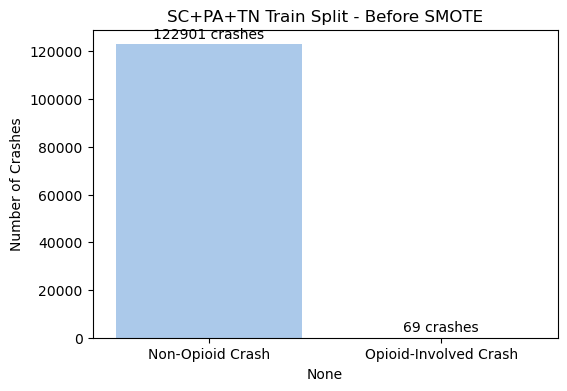

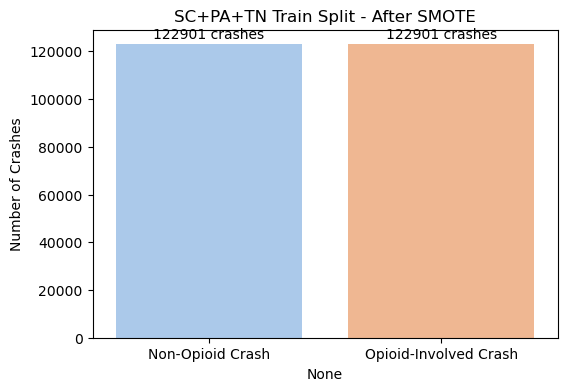


📈 Logistic Regression Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     26337
           1       0.01      0.79      0.02        14

    accuracy                           0.96     26351
   macro avg       0.50      0.87      0.50     26351
weighted avg       1.00      0.96      0.98     26351

ROC-AUC: 0.8465453273233203


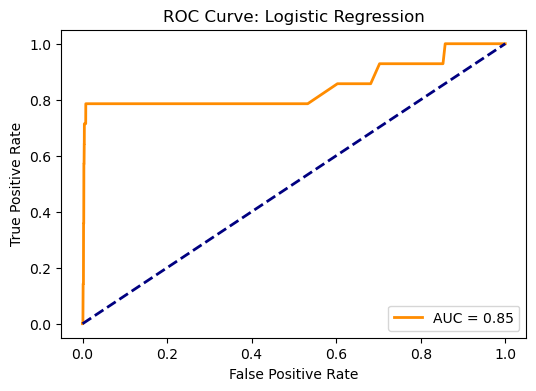


🌲 Random Forest Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     26337
           1       0.00      0.36      0.00        14

    accuracy                           0.90     26351
   macro avg       0.50      0.63      0.48     26351
weighted avg       1.00      0.90      0.95     26351

ROC-AUC: 0.7533291024577049


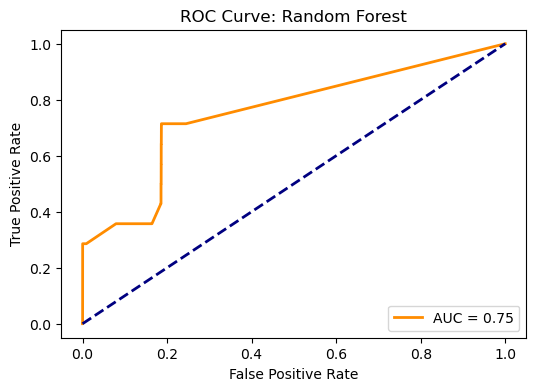


⚡ XGBoost Report
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     26337
           1       0.00      0.43      0.00        14

    accuracy                           0.90     26351
   macro avg       0.50      0.67      0.48     26351
weighted avg       1.00      0.90      0.95     26351

ROC-AUC: 0.852289554618977


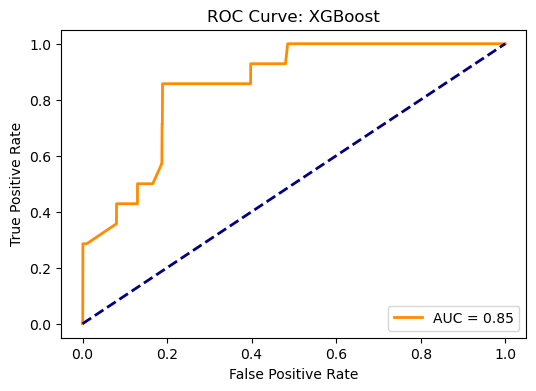


🔧 Regression Model Report
R²: -221.086
RMSE: 0.343


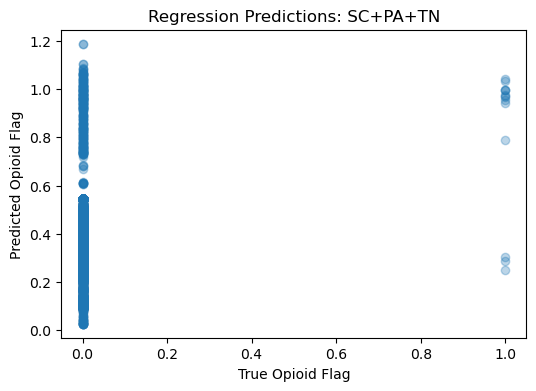

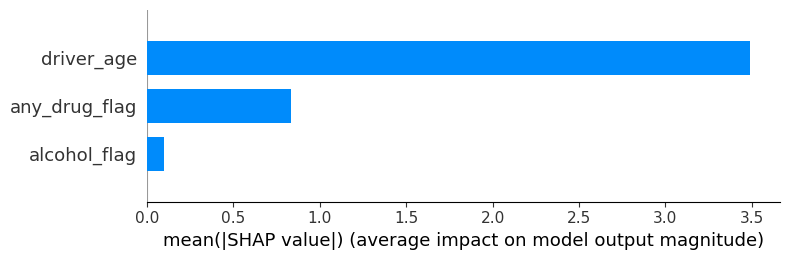


🚦 Running pipeline for FARS National Sample


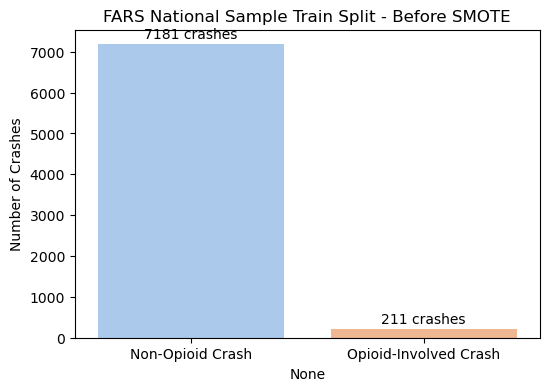

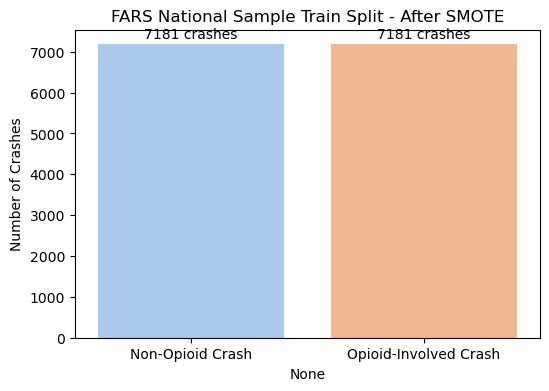


📈 Logistic Regression Report
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1539
           1       0.07      0.76      0.14        46

    accuracy                           0.72      1585
   macro avg       0.53      0.74      0.48      1585
weighted avg       0.96      0.72      0.81      1585

ROC-AUC: 0.7514902392858152


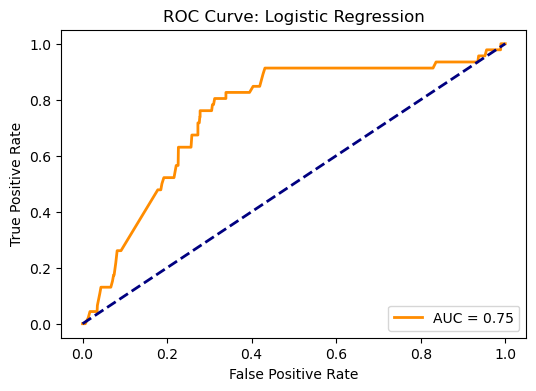


🌲 Random Forest Report
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      1539
           1       0.06      0.67      0.12        46

    accuracy                           0.70      1585
   macro avg       0.52      0.69      0.47      1585
weighted avg       0.96      0.70      0.80      1585

ROC-AUC: 0.6990069779924852


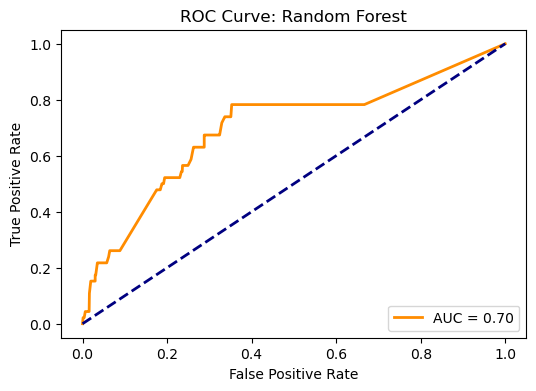


⚡ XGBoost Report
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      1539
           1       0.06      0.67      0.12        46

    accuracy                           0.70      1585
   macro avg       0.52      0.69      0.47      1585
weighted avg       0.96      0.70      0.80      1585

ROC-AUC: 0.6986679662118258


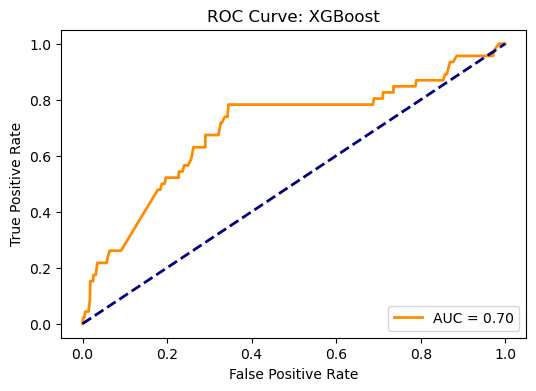


🔧 Regression Model Report
R²: -5.952
RMSE: 0.443


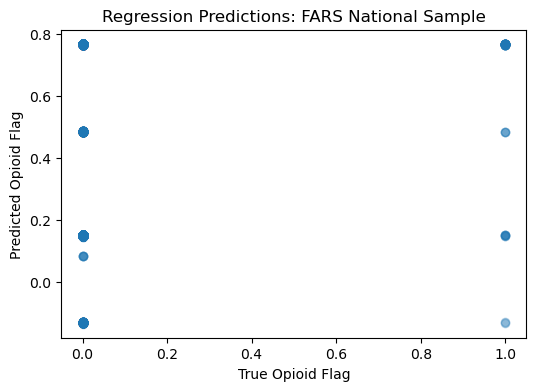

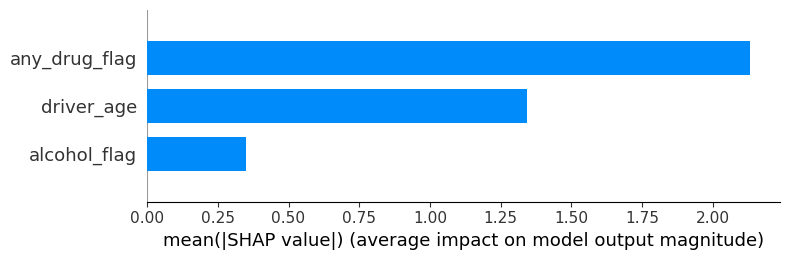

In [9]:
# Run full pipelines

run_pipeline(combined_df, "SC+PA+TN")
run_pipeline(fars_df, "FARS National Sample")